# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Arabic OCR</p>

In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten
from sklearn.metrics import accuracy_score,classification_report,roc_auc_score
from PIL import Image
import cv2

In [2]:
batch_size=64
learning_rate = 0.01
epochs=50
num_classes=29


# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Read and Preprocess the data</p>

In [3]:
training_Path='char_sample/'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_Path,
    color_mode='grayscale',
    subset='training',
    validation_split=0.1,
    
    image_size=(32,32),
  label_mode='categorical',
#   batch_size=128,
    seed=123
)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    training_Path,
    color_mode='grayscale',
    subset='validation',
    validation_split=0.1,

    image_size=(32,32),
  label_mode='categorical',
#   batch_size=128,
    seed=123
)


Found 127027 files belonging to 29 classes.
Using 114325 files for training.


2022-03-24 13:29:06.072023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 13:29:06.163305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 13:29:06.164136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 13:29:06.168131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 127027 files belonging to 29 classes.
Using 12702 files for validation.


In [4]:
X_train=np.concatenate([x for x,y in train_ds])
y_train=np.concatenate([y for x,y in train_ds])

X_test=np.concatenate([x for x,y in test_ds])
y_test=np.concatenate([y for x,y in test_ds])



2022-03-24 13:29:29.228765: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
X_train.shape

(114325, 32, 32, 1)

In [6]:
def display_images(X_train,row,col):
    fig = plt.figure(figsize=(12,12))
    ax = fig.subplots(row,col)
    for j in range(row):
        for i in range(col):
            fig.suptitle('Images')
            ax[j,i].imshow(X_train[random.randint(0,len(X_train))],cmap='gray')
            
    plt.plot()

# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Visualize the Images</p>

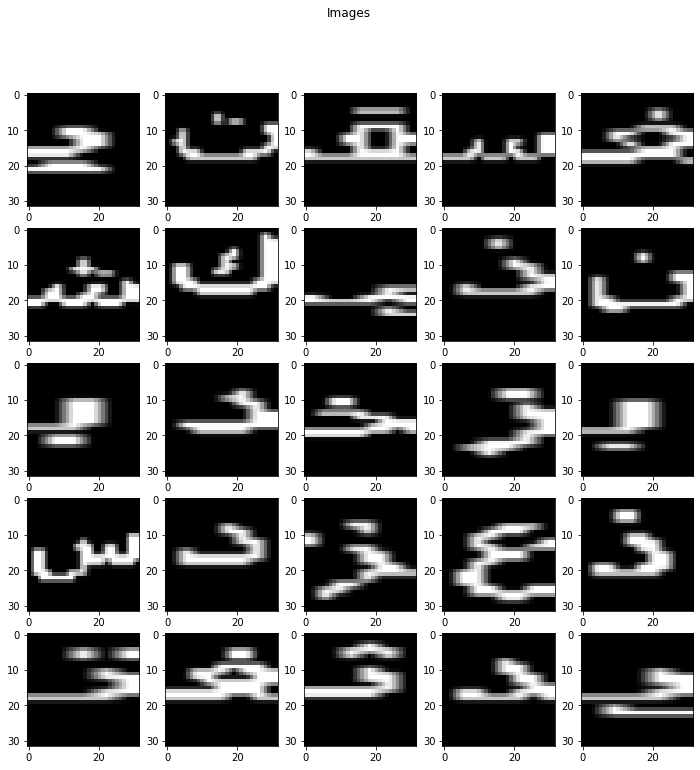

In [7]:
display_images(X_train,5,5)

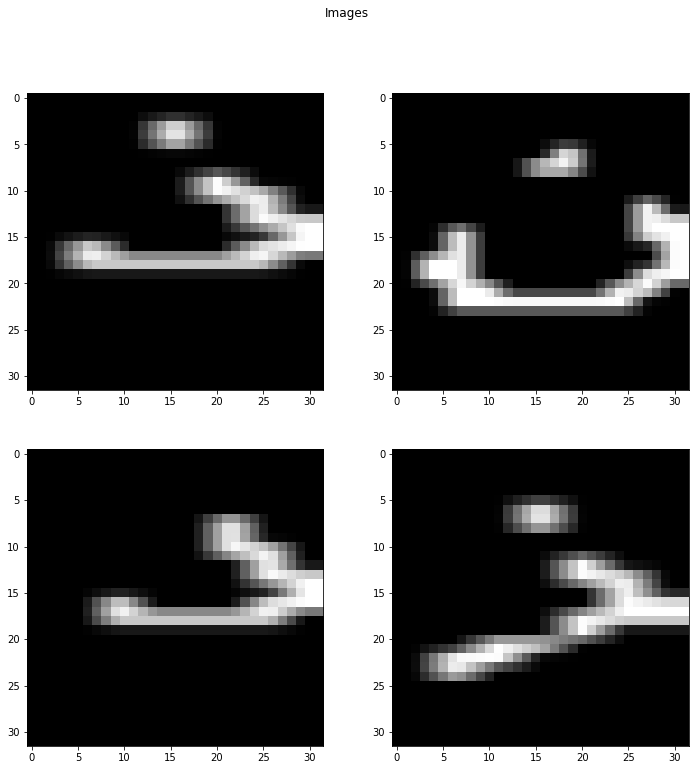

In [8]:
display_images(X_test,2,2)

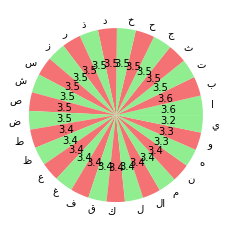

In [9]:

tr=pd.Series(np.argmax(y_train,axis=1))
classes=np.unique(y_train)
plt.pie(tr.value_counts(), labels=train_ds.class_names, colors=['#90EE91', '#F47174'], autopct='%1.1f')
plt.show()

# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Create an intialize the Model</p>

In [10]:


def create_model(activation='relu', optimizer='adam'):  
    with tf.device('/gpu:0'):
        model = Sequential()

        model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 1), activation= activation))
        model.add(MaxPooling2D(2,2))
        model.add(BatchNormalization())

        model.add(Conv2D(64, (3,3), padding='same', activation= activation))
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Conv2D(128, (3,3), padding='same', activation= activation, ))
        model.add(MaxPooling2D(2,2))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Flatten())

        model.add(Dense(32, activation= activation, kernel_regularizer='l2'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        model.add(Dense(29, activation='softmax'))

        model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    return model

In [11]:
model = create_model()                                                          # Now we created an instance of a model with our custom architefture.
model.summary()                                                                 # Then we display our model's summary.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          2

In [12]:
model = create_model(optimizer=tf.keras.optimizers.Adamax(0.001),
                     activation='relu')

In [13]:
X_train=np.array(X_train)

# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Training</p>

In [14]:
history = model.fit(train_ds, 
                    epochs=5,     
                    batch_size=128,validation_data=test_ds)

Epoch 1/5


2022-03-24 13:34:44.309258: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


3573/3573 [==============================] - 57s 14ms/step - loss: 0.5751 - accuracy: 0.9291 - val_loss: 0.0868 - val_accuracy: 0.9939
Epoch 2/5
3573/3573 [==============================] - 50s 14ms/step - loss: 0.0783 - accuracy: 0.9925 - val_loss: 0.0399 - val_accuracy: 0.9972
Epoch 3/5
3573/3573 [==============================] - 50s 14ms/step - loss: 0.0484 - accuracy: 0.9949 - val_loss: 0.0326 - val_accuracy: 0.9969
Epoch 4/5
3573/3573 [==============================] - 51s 14ms/step - loss: 0.0383 - accuracy: 0.9960 - val_loss: 0.0257 - val_accuracy: 0.9978
Epoch 5/5
3573/3573 [==============================] - 50s 14ms/step - loss: 0.0338 - accuracy: 0.9965 - val_loss: 0.0247 - val_accuracy: 0.9975


# <p style="background-color:#000000;font-family:newtimeroman;color:#FFFFFF;font-size:150%;text-align:center;border-radius:40px 40px;display:block;">Model Evaluation</p>

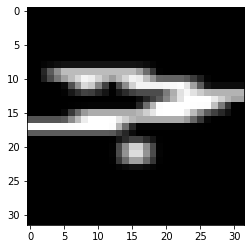

In [18]:
plt.imshow(X_test[5648],cmap='gray')
plt.show()

In [19]:
class_names=train_ds.class_names

y_pred = model.predict(np.array([X_test[5648]]))
# print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),target_names=class_names))
class_names[np.argmax(y_pred,axis=1)[0]]

'ج'

In [20]:
X_test[0]
np.argmax(y_pred,axis=1)

array([4])

In [23]:
def display_images_result(X_train,row,col):
    fig = plt.figure(figsize=(12,12))
    ax = fig.subplots(row,col)
    for j in range(row):
        for i in range(col):
            fig.suptitle('Images')
            idx=random.randint(0,len(X_train))
            
            ax[j,i].imshow(X_train[idx],cmap='gray')
            pred=model.predict(np.expand_dims(X_test[idx], axis=0))
            ax[j,i].set_title(class_names[np.argmax(pred,axis=1)[0]],fontdict={'fontsize':20,})
    plt.plot()

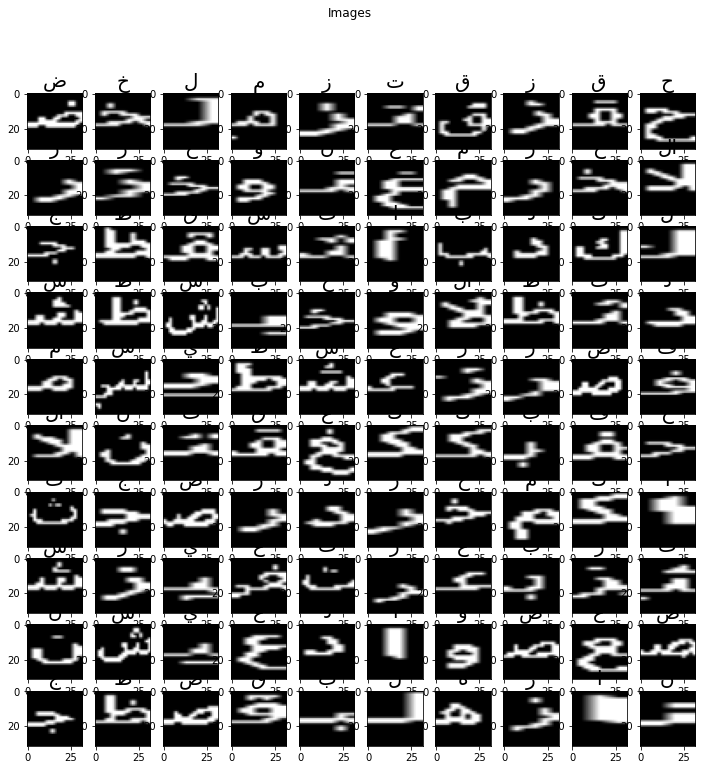

In [24]:
from matplotlib import rcParams
display_images_result(X_test,10,10)

In [40]:
model.save('model.hdf5')